<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   COLLEGE                      20000 non-null  object
 1   INCOME                       20000 non-null  int64 
 2   OVERAGE                      20000 non-null  int64 
 3   LEFTOVER                     20000 non-null  int64 
 4   HOUSE                        20000 non-null  int64 
 5   HANDSET_PRICE                20000 non-null  int64 
 6   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 7   AVERAGE_CALL_DURATION        20000 non-null  int64 
 8   REPORTED_SATISFACTION        20000 non-null  object
 9   REPORTED_USAGE_LEVEL         20000 non-null  object
 10  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 11  LEAVE                        20000 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB


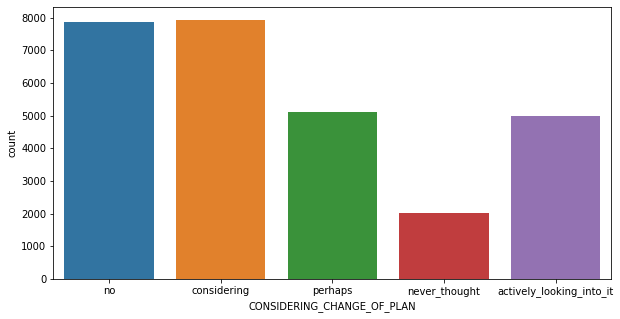

In [248]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []
aucs = []

# read the xlsx file
data_path = 'Customer_Churn.xlsx'
df = pd.read_excel(data_path)
df.head()
# finds out that there are no missing values and the datatypes of each entries
df.info()
# basic statistical informaiton of each attribute
df.describe()
df.isna().sum()
df['LEAVE'].value_counts()
df['COLLEGE'].value_counts()
plt.figure(figsize=(10,5))
sns.countplot(x='REPORTED_SATISFACTION',data=df)
sns.countplot(x='REPORTED_USAGE_LEVEL',data=df)
sns.countplot(x='CONSIDERING_CHANGE_OF_PLAN',data=df)






In [227]:
# Feature extraction: which is most informative
df = df.dropna()

In [228]:
# start to do onehot-enconding, transform category data to numeric data
# might do a for
df = pd.get_dummies(df, columns=['COLLEGE','LEAVE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN'])


In [231]:
# from the correlation graph, we can tell that the features that correlated the most with leave
# features will be used: INCOME, OVERAGE, LEFTOVER, HOUSE, HANDSET_PRICE, OVER_15MINS_CALLS_PER_MONTH
# There could be comparisons of employing all features or just the features above
#correlation matrix
df.corr()['LEAVE_LEAVE']

INCOME                                                 0.096320
OVERAGE                                                0.235139
LEFTOVER                                               0.060540
HOUSE                                                 -0.211213
HANDSET_PRICE                                          0.089221
OVER_15MINS_CALLS_PER_MONTH                            0.202193
AVERAGE_CALL_DURATION                                 -0.008704
COLLEGE_one                                            0.014673
COLLEGE_zero                                          -0.014673
LEAVE_LEAVE                                            1.000000
LEAVE_STAY                                            -1.000000
REPORTED_SATISFACTION_avg                             -0.011955
REPORTED_SATISFACTION_sat                             -0.012661
REPORTED_SATISFACTION_unsat                            0.009768
REPORTED_SATISFACTION_very_sat                        -0.004628
REPORTED_SATISFACTION_very_unsat        

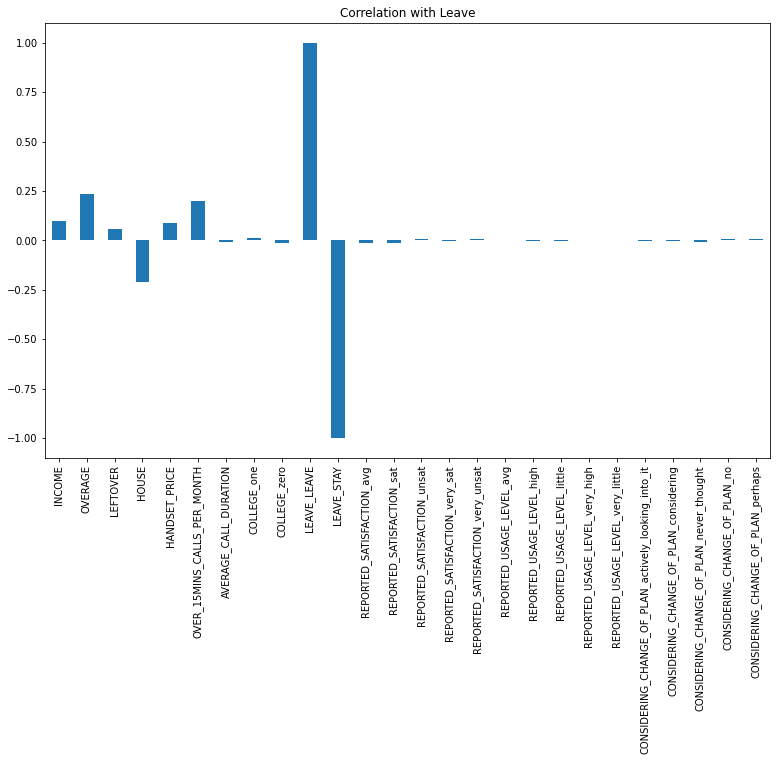

In [233]:
plt.figure(figsize=(13,8))
df.corr()['LEAVE_LEAVE'].plot(kind='bar',title='Correlation with Leave')

In [178]:
#split the set for training and test
features = ['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH','LEAVE_LEAVE']
cleaned_df = df[features]


In [179]:
#split the set as x and y
x = cleaned_df.drop('LEAVE_LEAVE',axis=1)
y = cleaned_df['LEAVE_LEAVE']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.33, random_state=42)


In [200]:
#before apply models, write functions about evaluation grpah
def roc_curve_model(x_test, y_test, y_probs):
  y_probability = y_probs[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probability)
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  print ("AUC for (ROC):",metrics.roc_auc_score(y_test, y_probability))

accuracy score: 0.6287878787878788
precision score: 0.6297709923664122
recall score: 0.6062461726883037
ROC score: 0.6285579993615483
f1 score: 0.6177847113884555
AUC for (ROC): 0.6861078182403937


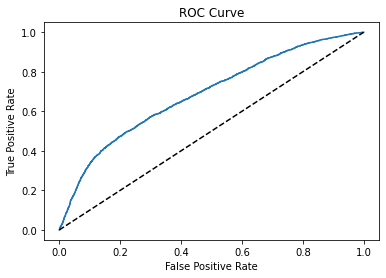

In [203]:
# applying model: 1)Logistic Regression; 2)knearestneighbors 3)Random Forest; 3)Decision Tree
#1）logistic regression
logis_model = LogisticRegression().fit(x_train, y_train)
#logis_model
log_y_predicted = logis_model.predict(x_test)
log_probs = logis_model.predict_proba(x_test)
classification_report(y_test, log_y_predicted)
print("accuracy score:",metrics.accuracy_score(y_test, log_y_predicted))
print("precision score:",metrics.precision_score(y_test, log_y_predicted))
print("recall score:",metrics.recall_score(y_test, log_y_predicted))
print("ROC score:",metrics.roc_auc_score(y_test, log_y_predicted))
print("f1 score:",metrics.f1_score(y_test, log_y_predicted))
roc_curve_model(x_test, y_test,log_probs)

accuracy score: 0.6034848484848485
precision score: 0.5858238561227188
recall score: 0.6781996325780771
ROC score: 0.6042467868949175
f1 score: 0.6286362991343833
AUC for (ROC): 0.6323306220568502


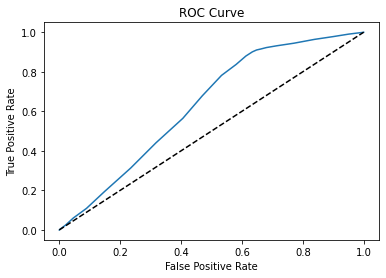

In [218]:
#2 Kneightbos algorithm
kneighbors = KNeighborsClassifier(n_neighbors=30,weights='uniform',metric='minkowski',).fit(x_train, y_train)
kneighbors_y_predicted = kneighbors.predict(x_test)
kneighbors_probs = kneighbors.predict_proba(x_test)
classification_report(y_test, kneighbors_y_predicted)
print("accuracy score:",metrics.accuracy_score(y_test, kneighbors_y_predicted))
print("precision score:",metrics.precision_score(y_test, kneighbors_y_predicted))
print("recall score:",metrics.recall_score(y_test, kneighbors_y_predicted))
print("ROC score:",metrics.roc_auc_score(y_test, kneighbors_y_predicted))
print("f1 score:",metrics.f1_score(y_test, kneighbors_y_predicted))
roc_curve_model(x_test, y_test,kneighbors_probs)

accuracy score: 0.6168181818181818
precision score: 0.6150483921323759
recall score: 0.6031843233312921
ROC score: 0.6166791442691254
f1 score: 0.6090585871077447
AUC for (ROC): 0.6166791442691254


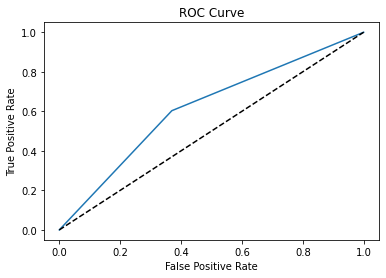

In [220]:
#3 Decision Tree
DT = DecisionTreeClassifier().fit(x_train,y_train)
DT_y_predicted = DT.predict(x_test)
DT_probs = DT.predict_proba(x_test)
classification_report(y_test, DT_y_predicted)
print("accuracy score:",metrics.accuracy_score(y_test, DT_y_predicted))
print("precision score:",metrics.precision_score(y_test, DT_y_predicted))
print("recall score:",metrics.recall_score(y_test, DT_y_predicted))
print("ROC score:",metrics.roc_auc_score(y_test, DT_y_predicted))
print("f1 score:",metrics.f1_score(y_test, DT_y_predicted))
roc_curve_model(x_test, y_test,DT_probs)
#cvs = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 10)

accuracy score: 0.6871212121212121
precision score: 0.6810370817003316
recall score: 0.6916717697489283
ROC score: 0.6871676185277334
f1 score: 0.6863132310496735
AUC for (ROC): 0.7473704279352336


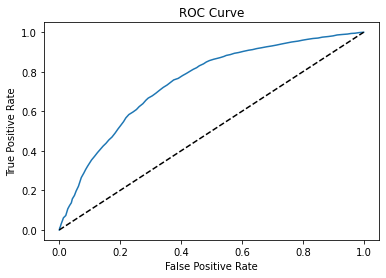

In [209]:
#4 Random Forests
randomF = RandomForestClassifier().fit(x_train,y_train)
randomF_y_predicted = randomF.predict(x_test)
randomF_probs = randomF.predict_proba(x_test)
classification_report(y_test, randomF_y_predicted)
print("accuracy score:",metrics.accuracy_score(y_test, randomF_y_predicted))
print("precision score:",metrics.precision_score(y_test, randomF_y_predicted))
print("recall score:",metrics.recall_score(y_test, randomF_y_predicted))
print("ROC score:",metrics.roc_auc_score(y_test, randomF_y_predicted))
print("f1 score:",metrics.f1_score(y_test, randomF_y_predicted))
roc_curve_model(x_test, y_test,randomF_probs)
